# Consumer Behavior Analytics - Data Modelling  of `customers_whole`

**Libraries and imports**

In [1]:
# Basic DS libraries
import pandas as pd
import numpy as np

# DataViz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics Libraries
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Data Utils
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
                                                                     recall_score, \
                                                                     precision_score, \
                                                                     accuracy_score
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression

# Notebook setup
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Loading customers exposed
customers_exposed = pd.read_csv('../data/customers_exposed.csv', parse_dates = ['Dt_Customer'])

# Loading customers whole
customers_whole = pd.read_csv('../data/customers_whole.csv', parse_dates = ['Dt_Customer'])

In [3]:
customers_exposed.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Income_PerCap,Prop_Spending_Income_pc,Avg_Ticket,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,58138.0,0.027813,64.68,57
1,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,1,10117.0,0.004547,7.67,40
2,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,0,1412.0,0.034703,24.50,64
3,2114,1946,PhD,Single,82800.0,0,0,2012-11-24,23,1006,22,115,59,68,45,1,7,6,12,3,0,0,1,1,0,0,1,82800.0,0.015882,50.58,68
4,6565,1949,Master,Married,76995.0,0,1,2013-03-28,91,1012,80,498,0,16,176,2,11,4,9,5,0,0,0,1,0,0,0,25665.0,0.069433,68.54,65


In [4]:
customers_exposed['Response'].value_counts(normalize = True)

1    0.5486
0    0.4514
Name: Response, dtype: float64

## Data Preparation

In [5]:
# Defining Sample first_date
first_date = customers_whole['Dt_Customer'].min()

# Transforming datetime feature to numeric feature
for df in [customers_exposed, customers_whole]:
    df['Dt_Customer_InDays'] = df['Dt_Customer'] - first_date
    
    df['Dt_Customer_InDays'] = (df['Dt_Customer_InDays'] / np.timedelta64(1, 'D')).astype(int) + 1
    
    # Dropping unuseful columns for modelling
    df.drop(['ID', 'Dt_Customer'], axis = 1, inplace = True)

In [6]:
# One Hot Encoding categorical features with pd.get_dummies
# customers_exposed_ohe = pd.get_dummies(customers_exposed)
customers_whole_ohe = pd.get_dummies(customers_whole)

In [7]:
# Splitting df_train and df_test for training and testing
df_train, df_test = train_test_split(customers_whole_ohe, test_size = .2, random_state = 7)

In [8]:
# Splitting df_train into df_train and df_val
df_train, df_val = train_test_split(df_train, test_size = .2, random_state = 7)

In [9]:
# Checking target variable balance (or unballance)
df_train['Response'].value_counts()

0    1217
1     211
Name: Response, dtype: int64

In [11]:
# Balancing target variable with SMOTE technique

# Instantiating SMOTER over_sampler
smote = SMOTE(random_state = 7)

# Fitting and resampling data with SMOTE
X_train, y_train = smote.fit_resample(df_train.drop('Response', axis = 1), df_train['Response'])

# Checking target class balance
y_train.value_counts()

0    1217
1    1217
Name: Response, dtype: int64

In [12]:
X_val = df_val.drop('Response', axis = 1)
y_val = df_val['Response']

X_test = df_test.drop('Response', axis = 1)
y_test = df_test['Response']

In [13]:
print('X_train, y_train   shapes: ', X_train.shape, y_train.shape)
print('X_val  , y_val     shapes: ', X_val.shape, y_val.shape)
print('X_test , y_test    shapes: ', X_test.shape, y_test.shape)

X_train, y_train   shapes:  (2434, 37) (2434,)
X_val  , y_val     shapes:  (358, 37) (358,)
X_test , y_test    shapes:  (447, 37) (447,)


In [14]:
X_train.columns

Index(['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Income_PerCap', 'Prop_Spending_Income_pc',
       'Avg_Ticket', 'Age', 'Dt_Customer_InDays', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow'],
      dtype='object')

In [15]:
# Separating numeric features in a list
numeric_features = [
#     'Year_Birth', 
    'Income', 
    'Kidhome',                
    'Teenhome', 
    'Recency', 
    'MntWines', 
    'MntFruits',
    'MntMeatProducts', 
    'MntFishProducts', 
    'MntSweetProducts',
    'MntGoldProds', 
    'NumDealsPurchases', 
    'NumWebPurchases',
    'NumCatalogPurchases', 
    'NumStorePurchases', 
    'NumWebVisitsMonth', 
    'Income_PerCap',
    'Prop_Spending_Income_pc', 
    'Avg_Ticket', 
    'Age', 
    'Dt_Customer_InDays'
]

In [16]:
vif_df = pd.DataFrame()
vif_df["vif_index"] = [vif(X_train[numeric_features].values, i) for i in range(X_train[numeric_features].shape[1])]
vif_df["feature"] = X_train[numeric_features].columns
vif_df

,vif_index,feature
0,38.658408,Income
1,3.005265,Kidhome
2,3.108448,Teenhome
3,3.422226,Recency
4,6.347232,MntWines
5,3.255204,MntFruits
6,6.611681,MntMeatProducts
7,3.559219,MntFishProducts
8,3.344452,MntSweetProducts
9,3.036579,MntGoldProds


In [17]:
# Listing features names if feature has outlier
to_robust_scale = []
for feature in numeric_features:
    
    Q1 = np.percentile(customers_exposed[feature].sort_values(), 25, interpolation = 'midpoint')  
    Q3 = np.percentile(customers_exposed[feature].sort_values(), 75, interpolation = 'midpoint')  

    IQR = Q3 - Q1  
    
    low_lim = Q1 - 1.5 * IQR 
    up_lim = Q3 + 1.5 * IQR 

    if (customers_exposed[feature] > up_lim).any() or (customers_exposed[feature] < low_lim).any(): 
         to_robust_scale.append(feature)

to_robust_scale

['MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebVisitsMonth',
 'Income_PerCap',
 'Prop_Spending_Income_pc',
 'Avg_Ticket']

In [18]:
to_standardize = [feature for feature in numeric_features if feature not in to_robust_scale]
to_standardize

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'Age',
 'Dt_Customer_InDays']

In [19]:
robust_scaler = RobustScaler()
robust_scaler.fit(X_train[to_robust_scale])
X_train[to_robust_scale] = robust_scaler.transform(X_train[to_robust_scale])

In [20]:
stand_scaler = StandardScaler()

stand_scaler.fit(X_train[to_standardize])
X_train[to_standardize] = stand_scaler.transform(X_train[to_standardize])

In [21]:
X_train.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Income_PerCap,Prop_Spending_Income_pc,Avg_Ticket,Age,Dt_Customer_InDays,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1952,-0.327407,-0.721502,1.202367,-1.284139,-0.317811,-0.048780,-0.057508,-0.064516,-0.250000,-0.196721,0.0,0.710111,-0.054059,-0.273343,-0.25,0,0,0,0,0,0,0.092126,-0.109534,-0.085148,1.535112,-0.711722,0,0,1,0,0,0,0,1,0,0
1,1965,0.196908,-0.721502,1.202367,1.121146,0.190758,-0.219512,-0.246006,-0.306452,-0.318182,-0.409836,-0.5,1.513462,-0.725387,0.383760,0.25,0,1,0,0,0,0,-0.058510,0.195506,-0.009137,0.374637,-1.180034,0,0,1,0,0,0,1,0,0,0
2,1961,0.239715,1.245056,1.202367,1.777132,-0.498098,-0.268293,-0.201278,-0.258065,-0.204545,0.016393,1.0,0.308435,-0.725387,-0.273343,0.00,0,0,0,0,0,0,-0.231638,-0.030141,-0.205095,0.731706,-1.468226,0,0,1,0,0,0,1,0,0,0
3,1962,0.793229,-0.721502,1.202367,-0.956146,2.203509,-0.317073,0.412141,0.000000,0.000000,2.803279,2.0,0.710111,-0.054059,2.355070,0.25,0,0,0,0,0,0,0.103000,1.843065,0.585346,0.642439,-0.577919,0,0,0,1,0,0,1,0,0,0
4,1976,-1.111357,1.245056,-0.746076,-1.357026,-1.014740,-0.292683,-0.322684,-0.241935,-0.204545,-0.442623,-0.5,-1.298267,-1.061051,-0.930446,0.25,0,0,0,0,0,0,-0.412845,-0.631115,-0.459179,-0.607304,0.106537,0,0,0,1,0,0,0,0,1,0


In [22]:
# Transforming x_val and x_test with scalers from X_train

X_val[to_robust_scale] = robust_scaler.transform(X_val[to_robust_scale])
X_test[to_robust_scale] = robust_scaler.transform(X_test[to_robust_scale])

X_val[to_standardize] = stand_scaler.transform(X_val[to_standardize])
X_test[to_standardize] = stand_scaler.transform(X_test[to_standardize])

In [23]:
y_train.value_counts()

0    1217
1    1217
Name: Response, dtype: int64

In [24]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [25]:
log_model.score(X_val, y_val)

0.8324022346368715

In [26]:
y_val_pred = log_model.predict(X_val)
y_test_pred = log_model.predict(X_test)

In [27]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       384
           1       0.50      0.75      0.60        63

    accuracy                           0.86       447
   macro avg       0.73      0.81      0.76       447
weighted avg       0.89      0.86      0.87       447



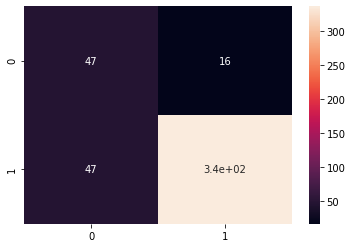

In [28]:
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels = [1, 0]), annot = True);

In [29]:
cv_log_model = cross_validate(log_model, X_train, y_train, cv = 10, scoring = ['accuracy', 'f1'])
cv_log_model

{'fit_time': array([0.05677509, 0.0385952 , 0.03705788, 0.0327301 , 0.03499317,
        0.03550196, 0.03527713, 0.03619218, 0.03361487, 0.03432798]),
 'score_time': array([0.00352883, 0.00286579, 0.0028491 , 0.00299478, 0.00282073,
        0.00283217, 0.0035069 , 0.00283909, 0.00283122, 0.00336003]),
 'test_accuracy': array([0.71721311, 0.76639344, 0.8852459 , 0.8852459 , 0.90123457,
        0.88477366, 0.89300412, 0.85596708, 0.91358025, 0.93415638]),
 'test_f1': array([0.64248705, 0.7510917 , 0.888     , 0.888     , 0.90625   ,
        0.8852459 , 0.89430894, 0.8582996 , 0.91828794, 0.93650794])}

In [30]:
cv_log_model['test_accuracy'].mean()

0.8636814410038453

In [31]:
cv_log_model['test_f1'].mean()

0.8568479063810497

In [32]:
LogisticRegression()


random_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'tol': stats.loguniform(0.1, 1),
    'C': stats.loguniform(3, 10)
    }

log_model_rand_search = RandomizedSearchCV(log_model, param_distributions = random_grid, 
                                           n_iter = 100, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)

In [33]:
log_model_rand_search.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12ce18df0>,
                                        'penalty': ['l2', 'l1', 'elasticnet'],
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12cbf9bb0>},
                   scoring='f1', verbose=1)

In [34]:
log_model_rand_search.best_params_

{'C': 3.2933287460837075, 'penalty': 'l2', 'tol': 0.1128770199138835}

In [35]:
y_val_pred_log_model_rand_search = log_model_rand_search.predict(X_val)

In [36]:
print(classification_report(y_val, y_val_pred_log_model_rand_search))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       299
           1       0.49      0.73      0.59        59

    accuracy                           0.83       358
   macro avg       0.71      0.79      0.74       358
weighted avg       0.87      0.83      0.84       358



## Baseline Model

LogisticRegression
KNNClassifier
SVC
RFClassifier
AdaBoost
GradientBoostClassifier
XGBoostClassifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from xgboost import XGBClassifier

In [38]:
models = {'logreg': LogisticRegression(),
          'knn_classifier': KNeighborsClassifier(),
          'SVM_classifier': SVC(),
          'RF_classifier': RandomForestClassifier(),
          'AdaBoost_classifier': AdaBoostClassifier(),
          'GradientBoosting_classifier': GradientBoostingClassifier(),
          'XGboost': XGBClassifier()}

In [39]:
models.keys(), models.values()

(dict_keys(['logreg', 'knn_classifier', 'SVM_classifier', 'RF_classifier', 'AdaBoost_classifier', 'GradientBoosting_classifier', 'XGboost']),
 dict_values([LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)]))

In [40]:
models.keys()

dict_keys(['logreg', 'knn_classifier', 'SVM_classifier', 'RF_classifier', 'AdaBoost_classifier', 'GradientBoosting_classifier', 'XGboost'])

In [41]:
model_teste = RandomForestClassifier()
model_teste.fit(X_train, y_train)

print(classification_report(y_val, model_teste.predict(X_val)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       299
           1       0.71      0.54      0.62        59

    accuracy                           0.89       358
   macro avg       0.81      0.75      0.78       358
weighted avg       0.88      0.89      0.88       358



In [42]:
param_grid_rf = {
            'n_estimators': [50, 60, 70, 80, 90, 100],
            'max_depth': np.arange(0, 10),
            'min_samples_split': np.arange(0, 10),
            'min_samples_leaf': stats.loguniform(.01, 1),
        }

In [43]:
param_grid_rf

{'n_estimators': [50, 60, 70, 80, 90, 100],
 'max_depth': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'min_samples_split': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x12cf20250>}

In [44]:
randforest_rsearch = RandomizedSearchCV(model_teste, param_distributions = param_grid_rf, n_iter = 100, 
                                        verbose = 1, n_jobs = -1, cv = 10)

randforest_rsearch.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12cf20250>,
                                        'min_samples_split': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100]},
                   verbose=1)

In [45]:
print(classification_report(y_val, randforest_rsearch.predict(X_val)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       299
           1       0.51      0.64      0.57        59

    accuracy                           0.84       358
   macro avg       0.72      0.76      0.73       358
weighted avg       0.86      0.84      0.85       358



In [46]:
for model_key, model_value in models.items():
    if model_key == 'logreg':
        param_grid = {
            'penalty': ['l2', 'l1', 'elasticnet'],
            'tol': stats.loguniform(0.1, 1),
            'C': stats.loguniform(3, 10)
        }
    elif model_key == 'knn_classifier':
        param_grid = {'n_neighbors':[3, 4, 5, 6, 7]}
    elif model_key == 'SVM_classifier':
        param_grid = {
            'C': stats.loguniform(3, 10)
        }
    elif model_key == 'RF_classifier':
        param_grid = {
            'n_estimators': [50, 60, 70, 80, 90, 100],
            'max_depth': np.arange(0, 10),
            'min_samples_split': np.arange(0, 10),
            'min_samples_leaf': stats.loguniform(.01, 1),
        }
    elif model_key == 'AdaBoost_classifier':
        param_grid = {
            'learning_rate': stats.lognorm(.001, 1)
        }
    elif model_key == 'GradientBoosting_classifier':
        param_grid = {
            'learning_rate': stats.lognorm(.001, 1),
            'n_estimators': [50, 60, 70, 80, 90, 100],
            'min_samples_split': np.arange(0, 10),
            'min_samples_leaf': stats.loguniform(.01, 1),
            'max_depth': np.arange(0, 10)
        }
    else:
        param_grid = {
            'n_estimators': [50, 60, 70, 80, 90, 100],
            'max_depth': np.arange(0, 10),
            'learning_rate': stats.lognorm(.001, 1),
            'gamma': stats.lognorm(.001, 1),
        } 
    print(f'######### {model_key} - Classification Report #########')   
    model_rsearch = RandomizedSearchCV(model_value, param_distributions = param_grid, n_iter = 100, scoring = 'f1',
                                       cv = 10, n_jobs = -1, verbose = 1)
    
    model_rsearch.fit(X_train, y_train)
    y_pred = model_rsearch.predict(X_test)
    print(classification_report(y_test, y_pred), '\n')

######### logreg - Classification Report #########
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       384
           1       0.51      0.73      0.60        63

    accuracy                           0.86       447
   macro avg       0.73      0.81      0.76       447
weighted avg       0.89      0.86      0.87       447
 

######### knn_classifier - Classification Report #########
Fitting 10 folds for each of 5 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       384
           1       0.32      0.60      0.42        63

    accuracy                           0.77       447
   macro avg       0.62      0.70      0.64       447
weighted avg       0.84      0.77      0.79       447
 

######### SVM_classifier - Classification Report #########
Fitting 10 folds for each of 100 candidates, to